# Rank significant covariates

## Import

In [2]:
import os
import sys
import logging
import multiprocessing
import pandas as pd
import numpy as np
import sqlalchemy
import exchange_calendars as xcals
from dotenv import load_dotenv

# import exchange_calendars as xcals
from datetime import datetime, timedelta

# import pytz
# import pandas as pd
# from IPython.display import display, HTML
from sqlalchemy import create_engine, text
from sqlalchemy.dialects.postgresql import insert
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

from neuralprophet import NeuralProphet, set_log_level, set_random_seed

# Disable logging messages unless there is an error
set_log_level("ERROR")

# from prophet.plot import (
#     plot_plotly,
#     plot_components_plotly,
#     add_changepoints_to_plot,
#     plot_yearly,
#     plot_seasonality_plotly,
# )

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Init

In [3]:
random_seed = 7

load_dotenv()  # take environment variables from .env.

module_path = os.getenv("LOCAL_AKSHARE_DEV_MODULE")
if module_path is not None and module_path not in sys.path:
    sys.path.insert(0, module_path)
import akshare as ak  # noqa: E402

print(ak.__version__)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create an engine instance
alchemyEngine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_recycle=3600,
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

file_handler = logging.FileHandler("etl.log")
console_handler = logging.StreamHandler()

# Step 4: Create a formatter
formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")

# Step 5: Attach the formatter to the handlers
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 6: Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

xshg = xcals.get_calendar("XSHG")

1.14.9


## Helper Functions

In [4]:
def train(df):
    set_random_seed(random_seed)
    m = NeuralProphet(
        weekly_seasonality=False,
        daily_seasonality=False,
        impute_missing=True,
    )
    covars = [col for col in df.columns if col not in ('ds', 'y')]
    m.add_lagged_regressor(covars)
    train_df, test_df = m.split_df(
        df,
        valid_p=1.0 / 10,
    )
    metrics = m.fit(
        train_df,
        validation_df=test_df,
        progress=None,
    )
    return metrics.tail()


## Anchor TS

In [5]:
# load anchor TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["ds"])

# Display the first few rows of the dataframe
df.head()

,ds,y,vol_cr,amt_cr,open,close,high,low,volume,amount
0,2020-02-10,NaN,NaN,NaN,8164.40,8265.17,8269.77,8136.36,339588.0,2.830927e+10
1,2020-02-11,0.43919,4.12706,-3.12677,8270.06,8301.47,8345.08,8243.03,353603.0,2.742411e+10
2,2020-02-12,0.41932,-23.45059,-24.08777,8294.21,8336.28,8336.28,8266.64,270681.0,2.081825e+10
3,2020-02-13,-0.71219,8.63045,18.12692,8329.26,8276.91,8368.77,8275.46,294042.0,2.459196e+10
4,2020-02-14,0.43060,-5.38256,-5.86328,8264.24,8312.55,8321.35,8264.24,278215.0,2.315006e+10


In [6]:
min_date = df['ds'].min().strftime("%Y-%m-%d")
# get a list of other China indices
query = f"""
    select distinct symbol 
    from index_daily_em_view 
    where symbol <> '{symbol}' and date <= '{min_date}'
"""
cov_symbols = pd.read_sql(query, alchemyEngine)
len(cov_symbols)

818

In [7]:
# rank = pd.DataFrame()
# cov_symbol = cov_symbols['symbol'].iloc[0]

def load_train(symbol):
    query = f"""
        select date ds, change_rate y_{symbol}
        from index_daily_em_view 
        where symbol = '{symbol}'
        and date >= '{min_date}'
        order by date
    """
    cov_symbol_df = pd.read_sql(query, alchemyEngine)
    merged_df = pd.merge(df, cov_symbol_df, on='ds', how="left")
    output = train(merged_df)
    # extract the last row of output, add symbol column, and consolidate to another dataframe
    last_row = output.iloc[[-1]]
    last_row['symbol'] = symbol
    return last_row
    # rank = pd.concat([rank, last_row], ignore_index=True)

# get the number of CPU cores
num_proc = int((multiprocessing.cpu_count() + 1) / 2.0)

results = []
# Use ThreadPoolExecutor to calculate metrics in parallel
with ThreadPoolExecutor(max_workers=num_proc) as executor:
    futures = [
        executor.submit(load_train, symbol)
        for symbol in cov_symbols["symbol"]
    ]
    for f in futures:
        try:
            results.append(f.result())
        except Exception as e:
            print(e)
    # results = [future.result() for future in futures]

You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat
You are trying t

In [ ]:
# results = []
# for f in futures:
#     try:
#         results.append(f.result())
#     except Exception as e:
#         print(e)
# results = [future.result() for future in futures]

In [9]:
results

[]

In [ ]:
# The list `results` has the following values for example:
# [      MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch      MAE      RMSE  \
#  119  0.582638  0.858642  0.027963          0.0    119  0.70209  0.930987   
 
#           Loss  RegLoss  symbol  
#  119  0.024924      0.0  000001  ,
#       MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
#  119   0.6185   0.88607  0.029783          0.0    119  0.724755  0.958793   
 
#           Loss  RegLoss  symbol  
#  119  0.025952      0.0  000002  ,
#        MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
#  119  0.873481  1.132213  0.048158          0.0    119  0.709102  0.937982   
 
# convert list `results` to dataframe
results_pd = pd.concat(results)
# rank the records in results by `Loss_val`, ascending.
results_pd.sort_values(by='Loss_val', inplace=True)
# save results_pd to csv file
results_pd.to_csv('results.csv', index=False)

In [ ]:
results_pd.head()

In [ ]:
# save the results_pd to database table. The table has been created using the following DDL:
# CREATE TABLE neuralprophet_corel (
#     symbol TEXT NOT NULL,
#     cov_symbol TEXT NOT NULL,
#     feature TEXT NOT NULL,
#     mae_val NUMERIC,
#     rmse_val NUMERIC,
#     loss_val numeric,
#     PRIMARY KEY (symbol, cov_symbol, feature)
# );

# Insert data into the table
insert_query = """
    INSERT INTO neuralprophet_corel 
        (symbol, cov_symbol, feature, mae_val, rmse_val, loss_val) 
    VALUES (%s, %s, %s, %s, %s, %s) 
    ON CONFLICT (symbol, cov_symbol, feature) 
    DO UPDATE SET 
        mae_val = EXCLUDED.mae_val, 
        rmse_val = EXCLUDED.rmse_val, 
        loss_val = EXCLUDED.loss_val
"""

with alchemyEngine.begin() as conn:
    # Inserting DataFrame into the database table
    for index, row in results_pd.iterrows():
        conn.execute(
            text("""
                INSERT INTO neuralprophet_corel 
                (symbol, cov_symbol, feature, mae_val, rmse_val, loss_val) 
                VALUES (:symbol, :cov_symbol, :feature, :mae_val, :rmse_val, :loss_val) 
                ON CONFLICT (symbol, cov_symbol, feature) 
                DO UPDATE SET mae_val = EXCLUDED.mae_val, rmse_val = EXCLUDED.rmse_val, loss_val = EXCLUDED.loss_val
            """),
            {
                "symbol": symbol,
                "cov_symbol": row["symbol"],
                "feature": "change_rate",
                "mae_val": row["MAE_val"],
                "rmse_val": row["RMSE_val"],
                "loss_val": row["Loss_val"],
            },
        )

In [ ]:
cov100 = results_pd.head(100)
cov100

In [10]:
# query records from `fund_etc_daily_em` table, where the `symbol` column is in the cov100 dataframe's `symbol` column.
cov100_symbols = cov100['symbol'].tolist()
# param_names = [f":s{i}" for i in range(len(cov100_symbols))]
# in_clause = ",".join(param_names)
query = """
    SELECT symbol ID, date DS, change_rate y
    FROM index_daily_em_view 
    where symbol in %(symbols)s
    order by ID, DS asc
"""
# params = {f"s{i}": s_val for i, s_val in enumerate(cov100_symbols)}
params = {'symbols': tuple(cov100_symbols)}
# with alchemyEngine.connect() as conn:
    # result = pd.read_sql_query(query, conn, params=params)
    # cov100_daily_df = pd.read_sql_query(query, conn, params=params, parse_dates=["ds"])
cov100_daily_df = pd.read_sql(query, alchemyEngine, params=params, parse_dates=["ds"])
len(cov100_daily_df)

NameError: name 'cov100' is not defined

In [ ]:
cov100_daily_df.isna().any()

In [ ]:
# show the data type of each column for df
df.dtypes

In [ ]:
merged_df = df[['ds','y']]
# merged_df['ds'] = pd.to_datetime(merged_df['ds'])

# merge and append the 'change_rate' column of cov_df to df, by matching dates
# split cov_df by symbol column
grouped = cov100_daily_df.groupby("id")
# sub_dfs = {group: data for group, data in grouped}
for group, sdf in grouped:
    sdf = sdf.rename(
        columns={
            "y": f"y_{group}",
        }
    )
    sdf = sdf[['ds', f"y_{group}"]]
    merged_df = pd.merge(merged_df, sdf[["ds", f"y_{group}"]], on='ds', how="left")

merged_df.describe()

## Train with Top-100 covariates

### T100-Default

In [11]:
def train_with_covars(epochs=None, **kwargs):
    set_random_seed(random_seed)
    m = NeuralProphet(
        **kwargs
    )
    covars = [col for col in merged_df.columns if col not in ('ds', 'y')]
    m.add_lagged_regressor(covars)
    train_df, test_df = m.split_df(
        merged_df,
        valid_p=1.0 / 10,
    )
    return m.fit(
        train_df,
        validation_df=test_df,
        progress=None,
        epochs=epochs,
    )

In [12]:
# baseline
train_with_covars(
    epochs=500, 
    weekly_seasonality=False,
    daily_seasonality=False,
    impute_missing=True,
)

NameError: name 'merged_df' is not defined

### Grid Search

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define your hyperparameters grid
param_grid = {
    "n_lags": list(range(2, 11)),
    "yearly_seasonality": list(range(10, 21)),
    "ar_layers": [[i] * i for i in range(2, 9)],
    "lagged_reg_layers": [[i] * i for i in range(2, 9)],
}
grid = ParameterGrid(param_grid)
len(grid)

In [ ]:
def grid_search(params):
    metrics = train_with_covars(
        epochs=500,
        n_lags=params["n_lags"],
        yearly_seasonality=params["yearly_seasonality"],
        ar_layers=params["ar_layers"],
        lagged_reg_layers=params["lagged_reg_layers"],
        weekly_seasonality=False,
        daily_seasonality=False,
        impute_missing=True,
    )
    # Evaluate the model
    # Here, we'll simply use the last validation loss as a proxy for performance. You might want to use a different metric.
    return params, metrics.iloc[-1]


# get the number of CPU cores
num_proc = int((multiprocessing.cpu_count()) / 1.2)

results = []
# Use ThreadPoolExecutor to calculate metrics in parallel
with ThreadPoolExecutor(max_workers=num_proc) as executor:
    futures = [executor.submit(grid_search, params) for params in grid]
    for f in futures:
        try:
            results.append(f.result())
        except Exception as e:
            print(e)


# Sort the results based on 'Loss_val'
sorted_results = sorted(results, key=lambda x: x[1]["Loss_val"])

# Print the top 10 results
for params, metrics in sorted_results[:10]:
    print(f"Params: {params}, Metrics: {metrics}")

In [ ]:
print(grid[0], hash(grid[0]))
# for p in grid:
    # print()
    # sort p (which is a dict) by its key string, and then stringify p (hash it so that the hash of dict with the same key and value pairs shall be identical.)
    # p_sorted = dict(sorted(p.items()))
    # p_hash = hash(frozenset(p_sorted.items()))
    # print(p_hash)
    

# Multivariate Experiements

## Benchmark

### Close CR + Turnover CR

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#default)|0.587409|0.873636|0.028510|-0.0037|0.961|
|[FT15,AR5,ARnet4x4](#ft15ar5arnet4x4)|0.544901|0.809492|0.024314|0.0233|0.91|
|[FT15,AR5,ARnet5x8](#ft15ar5arnet5x8)|0.544550|0.821479|0.025064|0.00335|0.912|
|[FT15,AR5,4x4,2x2](#ft15ar54x42x2)|0.532781|0.809360|0.024468|0.00663|0.925|
|[FT15,AR5,4x4,4x4](#ft15ar54x44x4)|0.541571|0.817784|0.024822|-0.0141|0.9203|

### Close CR + Volume CR

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#default)|0.588967|0.875254|0.028560|-0.003|0.962|

### Close CR + Volume CR + Turnover CR

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#default)|0.585862|0.872914|0.028530|0.00583|0.96|

### Bond

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#bond---default)|0.547821|0.801297|0.023871|0.02|0.925|
|[2x2](#bond---2x2)|0.543448|0.803755|0.024142|0.0102|0.9152|
|[4x4](#bond---4x4)|0.551836|0.823901|0.025290|-0.0117|0.914|


## Import

In [ ]:
import os
import sys
import logging
import multiprocessing
import pandas as pd
import numpy as np
import sqlalchemy
import exchange_calendars as xcals
from dotenv import load_dotenv

# import exchange_calendars as xcals
from datetime import datetime, timedelta

# import pytz
# import pandas as pd
# from IPython.display import display, HTML
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import insert, TEXT
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

from neuralprophet import NeuralProphet, set_log_level, set_random_seed

# Disable logging messages unless there is an error
set_log_level("ERROR")

# from prophet.plot import (
#     plot_plotly,
#     plot_components_plotly,
#     add_changepoints_to_plot,
#     plot_yearly,
#     plot_seasonality_plotly,
# )

## Init

In [ ]:
random_seed = 7

load_dotenv()  # take environment variables from .env.

module_path = os.getenv("LOCAL_AKSHARE_DEV_MODULE")
if module_path is not None and module_path not in sys.path:
    sys.path.insert(0, module_path)
import akshare as ak  # noqa: E402

print(ak.__version__)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create an engine instance
alchemyEngine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_recycle=3600,
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

file_handler = logging.FileHandler("etl.log")
console_handler = logging.StreamHandler()

# Step 4: Create a formatter
formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")

# Step 5: Attach the formatter to the handlers
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 6: Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

xshg = xcals.get_calendar("XSHG")

## Helper Functions

In [ ]:
def predict(
    symbol, y_column, country=None, fourier_terms="auto", show_uncertainty=False
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    return predict_generic(
        "fund_etf_daily_em", symbol, y_column, country, fourier_terms, show_uncertainty
    )


def predict_generic(
    table,
    symbol,
    y_column,
    country=None,
    fourier_terms="auto",
    show_uncertainty=False,
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    query = f"SELECT * FROM {table} where symbol = '{symbol}' order by date"
    df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

    df = df.rename(
        columns={
            "date": "ds",
            y_column: "y",
        }
    )

    m = NeuralProphet(
        mcmc_samples=300 if show_uncertainty else 0,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=fourier_terms,
    )  # Prophet object can only be fit once. Instantiate a new object.
    if country is not None:
        m.add_country_holidays(country_name=country)
    m.fit(df)

    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    return (m, df, forecast)

## Trial 1 - Close CR + Turnover CR

#### load data from table

In [ ]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

In [ ]:
df.describe()

In [ ]:
fig = df.plot(
    x="ds", y=["y", "amt_cr"], figsize=(10, 6)
)

In [ ]:
df = df[["ds", "y", "amt_cr"]]

In [ ]:
# check if any nan value in df
df.isnull().any()

#### Default

In [ ]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

#### FT15,AR5,ARnet4x4

In [ ]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

#### FT15,AR5,ARnet5x8

In [ ]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[8] * 5,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

#### FT15,AR5,4x4,2x2

In [ ]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[2] * 2,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

#### FT15,AR5,4x4,4x4

In [ ]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[4] * 4,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

## Trial 2: Close CR + Vol CR

#### load data from table

In [15]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

,ds,y,vol_cr,amt_cr,open,close,high,low,volume,amount
0,2020-02-10,NaN,NaN,NaN,8164.40,8265.17,8269.77,8136.36,339588.0,2.830927e+10
1,2020-02-11,0.43919,4.12706,-3.12677,8270.06,8301.47,8345.08,8243.03,353603.0,2.742411e+10
2,2020-02-12,0.41932,-23.45059,-24.08777,8294.21,8336.28,8336.28,8266.64,270681.0,2.081825e+10
3,2020-02-13,-0.71219,8.63045,18.12692,8329.26,8276.91,8368.77,8275.46,294042.0,2.459196e+10
4,2020-02-14,0.43060,-5.38256,-5.86328,8264.24,8312.55,8321.35,8264.24,278215.0,2.315006e+10


In [16]:
df.describe()

,y,vol_cr,amt_cr,open,close,high,low,volume,amount
count,1067.000000,1067.000000,1067.000000,1068.000000,1068.000000,1068.000000,1068.00000,1.068000e+03,1.068000e+03
mean,0.030895,8.996093,2.214333,9831.537846,9837.112360,9891.475140,9776.02089,4.002090e+07,3.241195e+10
std,0.958547,225.069217,22.427483,910.671564,911.222865,917.909602,906.34000,1.752931e+07,1.289134e+10
min,-4.846510,-49.226620,-46.459390,7815.320000,7773.610000,7860.320000,7735.28000,1.802400e+05,1.329714e+10
25%,-0.490375,-12.848575,-13.001285,9159.687500,9160.967500,9215.910000,9119.56000,3.136401e+07,2.405860e+10
50%,0.007120,-0.690070,-1.048420,9757.150000,9764.605000,9812.845000,9713.60000,3.831309e+07,3.013646e+10
75%,0.558855,13.562710,12.646020,10620.365000,10623.992500,10683.257500,10577.70250,4.721252e+07,3.694442e+10
max,6.564060,7320.541840,143.149540,11816.260000,11783.600000,11940.710000,11680.66000,1.436950e+08,1.213817e+11


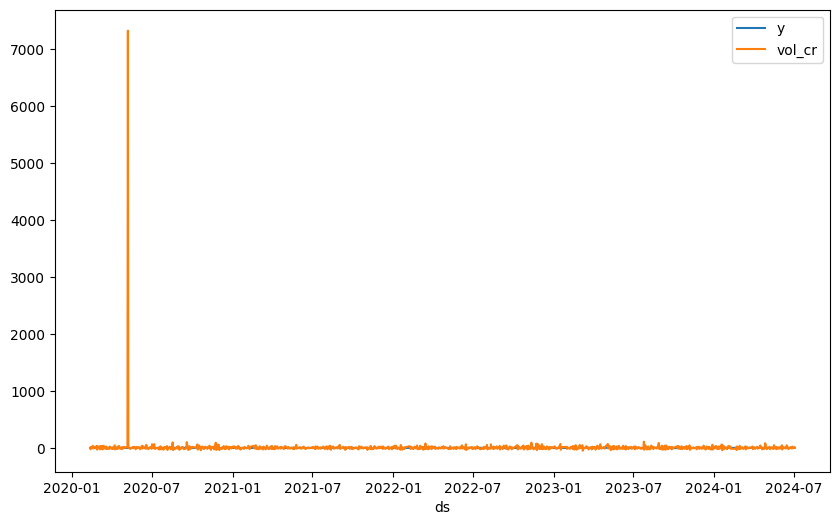

In [17]:
fig = df.plot(
    x="ds", y=["y", "vol_cr"], figsize=(10, 6)
)

In [8]:
df = df[["ds", "y", "vol_cr"]]

In [19]:
# check if any nan value in df
df.isnull().any()

ds        False
y          True
vol_cr     True
dtype: bool

#### Default

In [9]:
set_random_seed(random_seed)
from marten.models.hp_search import default_params
m = NeuralProphet(
    # weekly_seasonality=False,
    # daily_seasonality=False,
    # **default_params,
)

m.add_lagged_regressor(["vol_cr"])

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((961, 3), (106, 3))

In [10]:
metrics = m.fit(
    df,
    # validation_df=test_df,
    progress=None,
    freq="B",
)
metrics

Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,6.145396,9.363138,0.602927,0.0,0
1,4.877995,7.862712,0.453927,0.0,1
2,3.744199,6.492391,0.325617,0.0,2
3,2.667979,4.987008,0.206176,0.0,3
4,2.559764,5.081649,0.174310,0.0,4
...,...,...,...,...,...
105,0.713613,0.962849,0.026146,0.0,105
106,0.695811,0.927546,0.025005,0.0,106
107,0.696986,0.925948,0.025100,0.0,107
108,0.693783,0.925837,0.024919,0.0,108


In [43]:
df

,ds,y,vol_cr
0,2020-02-10,NaN,NaN
1,2020-02-11,0.43919,4.12706
2,2020-02-12,0.41932,-23.45059
3,2020-02-13,-0.71219,8.63045
4,2020-02-14,0.43060,-5.38256
...,...,...,...
1063,2024-06-26,0.31105,-11.07360
1064,2024-06-27,-0.62872,21.83282
1065,2024-06-28,0.37345,-1.70466
1066,2024-07-01,1.58433,-2.26830


In [12]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=0)
forecast = m.predict(future)

In [49]:
forecast

,ds,y,yhat1,lagged_regressor_vol_cr1,trend,season_yearly,season_weekly
0,2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-11,0.43919,0.015794,0.004820,0.384614,0.070658,-0.444298
2,2020-02-12,0.41932,-0.059160,0.004820,0.385683,0.070928,-0.520591
3,2020-02-13,-0.71219,-0.009832,0.002329,0.386752,0.071203,-0.470116
4,2020-02-14,0.43060,-0.021535,0.005227,0.387821,0.071454,-0.486036
...,...,...,...,...,...,...,...
1063,2024-06-26,0.31105,-0.230548,0.003990,0.324818,-0.036280,-0.523075
1064,2024-06-27,-0.62872,-0.176828,0.003447,0.324359,-0.036285,-0.468349
1065,2024-06-28,0.37345,-0.191893,0.006419,0.323900,-0.036645,-0.485566
1066,2024-07-01,1.58433,-0.176301,0.004293,0.322525,-0.039884,-0.463235


In [13]:
# Impute missing values
for col in df.columns:
    if col != "ds" and col != "y":
        df[col].fillna(forecast[col], inplace=True)

KeyError: 'vol_cr'

In [50]:
df

,ds,y,vol_cr
0,2020-02-10,NaN,NaN
1,2020-02-11,0.43919,4.12706
2,2020-02-12,0.41932,-23.45059
3,2020-02-13,-0.71219,8.63045
4,2020-02-14,0.43060,-5.38256
...,...,...,...
1063,2024-06-26,0.31105,-11.07360
1064,2024-06-27,-0.62872,21.83282
1065,2024-06-28,0.37345,-1.70466
1066,2024-07-01,1.58433,-2.26830


In [34]:
forecast = m.predict(df.copy())

In [36]:
df

,ds,y,vol_cr
0,2020-02-10,NaN,NaN
1,2020-02-11,0.43919,4.12706
2,2020-02-12,0.41932,-23.45059
3,2020-02-13,-0.71219,8.63045
4,2020-02-14,0.43060,-5.38256
...,...,...,...
1063,2024-06-26,0.31105,-11.07360
1064,2024-06-27,-0.62872,21.83282
1065,2024-06-28,0.37345,-1.70466
1066,2024-07-01,1.58433,-2.26830


In [35]:
forecast

,ds,y,yhat1,lagged_regressor_vol_cr1,trend,season_yearly
0,2020-02-10,NaN,NaN,NaN,NaN,NaN
1,2020-02-11,0.43919,0.013380,0.005592,-0.111183,0.118970
2,2020-02-12,0.41932,0.014873,0.005592,-0.110284,0.119565
3,2020-02-13,-0.71219,0.013289,0.002702,-0.109386,0.119974
4,2020-02-14,0.43060,0.017744,0.006064,-0.108487,0.120167
...,...,...,...,...,...,...
1063,2024-06-26,0.31105,-0.063322,0.004629,-0.038305,-0.029646
1064,2024-06-27,-0.62872,-0.061196,0.003999,-0.038503,-0.026692
1065,2024-06-28,0.37345,-0.055467,0.007448,-0.038701,-0.024214
1066,2024-07-01,1.58433,-0.054273,0.004981,-0.039294,-0.019959


In [51]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = np.sqrt(
    (forecast["yhat1"]
    - forecast["y"])**2
).mean()
std_diff = np.sqrt(
    (forecast["yhat1"]
    - forecast["y"])**2
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.6988707588267303, Standard deviation of difference: 0.6494281842494211


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

## Trial 3: Close CR + Vol CR + Turnover CR

#### load data from table

In [ ]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

In [ ]:
df.describe()

In [ ]:
fig = df.plot(
    x="ds", y=["y", "vol_cr", "amt_cr"], figsize=(10, 6)
)

In [ ]:
df = df[["ds", "y", "vol_cr", "amt_cr"]]

In [ ]:
# check if any nan value in df
df.isnull().any()

#### Default

In [ ]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
)

m.add_lagged_regressor(["vol_cr", "amt_cr"])

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

## Trial X - Include More Time Series

#### load data from database

In [ ]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

# 159981 能源化工ETF
# 518880 黄金ETF
# 159985 豆粕ETF
# 511220 城投债ETF
cov_symbol_list = "('518880', '159981', '159985', '511220')"
query = f"""
    SELECT symbol, date DS, change_rate y 
    FROM fund_etf_daily_em 
    where symbol in {cov_symbol_list}
    order by DS asc
"""
cov_df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

In [ ]:
# merge and append the 'change_rate' column of cov_df to df, by matching dates
# split cov_df by symbol column
grouped = cov_df.groupby("symbol")
# sub_dfs = {group: data for group, data in grouped}

for group, sdf in grouped:
    sdf = sdf.rename(
        columns={
            "y": f"{group}_y",
        }
    )
    df = pd.merge(df, sdf[["ds", f"{group}_y"]], on='ds', how="left")

df.head()

In [ ]:
fig = df.plot(
    x="ds", y=["y", "159981_y", "159985_y", "511220_y", "518880_y"], figsize=(10, 6)
)

In [ ]:
df.isna().any()

#### Bond - Default

In [ ]:
set_random_seed(random_seed)

mv_df = df[['ds','y', '511220_y']]

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
)

m.add_lagged_regressor(["511220_y"])

train_df, test_df = m.split_df(
    mv_df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(mv_df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

#### Bond - 2x2

In [ ]:
set_random_seed(random_seed)

mv_df = df[['ds','y', '511220_y']]

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[2] * 2,
)

m.add_lagged_regressor(["511220_y"])

train_df, test_df = m.split_df(
    mv_df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(mv_df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()

#### Bond - 4x4

In [ ]:
set_random_seed(random_seed)

mv_df = df[['ds','y', '511220_y']]

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[4] * 4,
)

m.add_lagged_regressor(["511220_y"])

train_df, test_df = m.split_df(
    mv_df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

In [ ]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

In [ ]:
future = m.make_future_dataframe(mv_df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

In [ ]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
)

In [ ]:
m.plot_parameters()